In [2]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [14]:
import pyodbc
import pandas as pd

# Paramètres de connexion
server = 'IHEB\\SQLEXPRESS'  # Nom du serveur avec échappement du backslash
database = 'SAP'  # Remplace par le nom de ta base de données

# Création de la connexion ODBC avec l'authentification Windows
conn = pyodbc.connect(f'DRIVER={{ODBC Driver 17 for SQL Server}};'
                      f'SERVER={server};'
                      f'DATABASE={database};'
                      'Trusted_Connection=yes')

# Exemple de requête SQL
query = "SELECT * FROM [SAP].[dbo].[FACT_SUPPLIER_IMPACT_FINALE]"  # Remplace 'ta_table' par le nom de la table que tu veux importer

# Importation des données dans un DataFrame Pandas
df = pd.read_sql(query, conn)

# Affichage des premières lignes du DataFrame
df.head()

C:\Users\medih\AppData\Local\Temp\ipykernel_10376\1330932951.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Renewable_Energy_Percentage,Recycled_Packaging,Water_Consumption_per_Unit_liters,FK_Date,FK_Supplier
0,32.085453,0,3610,20011002,34681
1,59.605011,0,3560,20011003,29269
2,99.573448,1,4040,20011004,30203
3,43.526230,1,1215,20011005,43051
4,92.069138,0,522,20011006,36249


In [18]:
df = df.dropna(subset=['Water_Consumption_per_Unit_liters'])

In [20]:
df_sample = df.sample(frac=1.0, random_state=42)

In [24]:
y = df_sample['Water_Consumption_per_Unit_liters']
X = df_sample.drop(columns=['Water_Consumption_per_Unit_liters'])

In [26]:
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [28]:
reg = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [32]:
#caractéristiques du supplier
user_input = {
    "FK_Supplier": input("FK_Supplier : ")
    
}
# 🔸 Convertir en DataFrame
user_df = pd.DataFrame([user_input])

# 🔸 Encodage identique à celui de l'entraînement
user_encoded = pd.get_dummies(user_df)
user_encoded = user_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# 🔮 Prédiction
predicted_price = reg.predict(user_encoded)[0]
print(f"\n💸 Water_Consumption_per_Unit_liters prédit pour ce supplier : {predicted_price:.2f} ")

FK_Supplier :  34681



💸 Water_Consumption_per_Unit_liters prédit pour ce supplier : 2553.39 


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np  # Nécessaire pour la racine carrée

# 📊 Prédictions sur les données de test
y_pred = reg.predict(X_test)

# 📈 Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📐 RMSE (Racine de l'erreur quadratique moyenne) : {rmse:.2f}")
print(f"📈 R² (valeur du coefficient de détermination) : {abs(r2):.2f}")

📐 RMSE (Racine de l'erreur quadratique moyenne) : 3484.17
📈 R² (valeur du coefficient de détermination) : 0.66


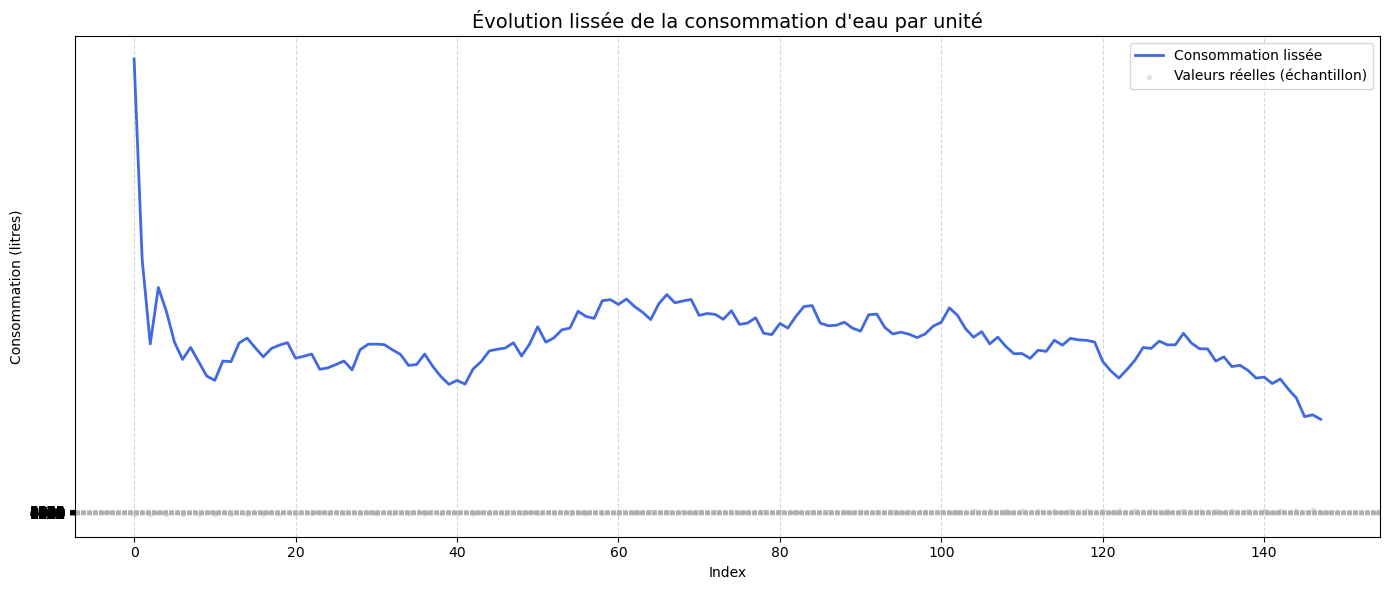

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Tri par index pour une courbe cohérente (ou par Date si dispo)
if 'Date' in df_sample.columns:
    df_sample_sorted = df_sample.sort_values('Date')
    x = df_sample_sorted['Date']
else:
    df_sample_sorted = df_sample.reset_index(drop=True)
    x = df_sample_sorted.index  # index numérique

# Lissage optionnel pour rendre la courbe plus fluide
window_size = 20  # taille de la fenêtre de lissage
y_smoothed = df_sample_sorted['Water_Consumption_per_Unit_liters'].rolling(window=window_size, min_periods=1).mean()

# Tracé
plt.figure(figsize=(14, 6))
plt.plot(x, y_smoothed, label='Consommation lissée', color='royalblue', linewidth=2)
plt.scatter(x[::len(x)//50], df_sample_sorted['Water_Consumption_per_Unit_liters'].iloc[::len(x)//50],
            color='lightgray', alpha=0.5, s=10, label='Valeurs réelles (échantillon)')  # échantillon points bruts
plt.title('Évolution lissée de la consommation d\'eau par unité', fontsize=14)
plt.xlabel('Index' if 'Date' not in df_sample.columns else 'Date')
plt.ylabel('Consommation (litres)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
